# Figure 5: tracking holes in the MCF10A epithelial monolayer after doxorubicin treatment

Dataset `MCF10A_TimeLapse_Chemotherapy\2021-07-02_MCF10Amut_H2B-ERKKTRturq-FoxoNGreen_Doxorubicin_20x_T5min`

## Definitions

In [15]:
import os
import gc

import numpy as np
import pandas as pd
from scipy import ndimage

import napari
from napari_timestamper import render_as_rgb, save_image_stack

from arcos4py.tools import track_events_image

# TIFF stacks I/O
from tifffile import imread, imwrite

from skimage import io
from skimage import measure
from skimage.morphology import binary_opening, square
from skimage.measure import regionprops_table

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# set font to arial
plt.rcParams['font.sans-serif'] = "Arial"
sns.set_theme(style='white')

import plotnine as p9
from mizani.formatters import percent_format

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

In [17]:
IMG_NAPARI = True  # Whether to show images in napari
DATA_SAVE = True  # Whether to save intermediate data
PLOT_SAVE = True # Whether to save plots

DIR_CORE = "../../data/5_hole_tracking"
DIR_IN = f"{DIR_CORE}/input-data"
DIR_OUT_DATA = f"{DIR_CORE}/output-data"
DIR_OUT_PLOT = f"{DIR_CORE}/output-plots"
DIR_OUT_VIDEO = f"{DIR_CORE}/output-videos"

PXSZ = 664.66 / 1024  # pixel size in um
SAMPLE_PERIOD_MIN = 5 # sample period in minutes

colpal = [(0.298, 0.447, 0.690),
          (0.867, 0.518, 0.322),
          (0.333, 0.659, 0.408),
          (0.769, 0.306, 0.322)]

# Convert RGB colors in colpal to hex format
colpal_hex = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in colpal]

v_cond_order = ["Control", "Low", "Medium", "High"]

def filter_tracks_vec(tracks, threshold):
    # Initialize a dictionary to hold the count of unique track IDs per frame
    track_id_counts = {}

    # Iterate over each frame and count each unique track ID only once per frame
    for frame in range(tracks.shape[0]):
        unique_track_ids_in_frame = np.unique(tracks[frame])
        for track_id in unique_track_ids_in_frame:
            if track_id == 0:  # Skip the background track ID
                continue
            if track_id not in track_id_counts:
                track_id_counts[track_id] = 1
            else:
                track_id_counts[track_id] += 1

    # Identify track_ids that meet the threshold requirement
    valid_track_ids = [track_id for track_id, count in track_id_counts.items() if count > threshold]

    # Create a mask for valid track_ids
    mask = np.isin(tracks, valid_track_ids)

    # Apply the mask to filter tracks, setting invalid tracks to 0
    filtered_tracks = np.where(mask, tracks, 0)

    return filtered_tracks



In [18]:
# Create directories for outputting plots and data

if not os.path.exists(DIR_OUT_DATA):
    os.makedirs(DIR_OUT_DATA)
    print(f"Directory {DIR_OUT_DATA} created successfully!")
else:
    print(f"Directory {DIR_OUT_DATA} already exists!")

if not os.path.exists(DIR_OUT_PLOT):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_PLOT} created successfully!")
else:
    print(f"Directory {DIR_OUT_PLOT} already exists!")

if not os.path.exists(DIR_OUT_VIDEO):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_VIDEO} created successfully!")
else:
    print(f"Directory {DIR_OUT_VIDEO} already exists!")

Directory ../../data/5_hole_tracking/output-data already exists!
Directory ../../data/5_hole_tracking/output-plots already exists!
Directory ../../data/5_hole_tracking/output-videos already exists!


## Load data

In [12]:
im_raw_path = f"{DIR_IN}/raw/"
im_seg_path = f"{DIR_IN}/segmented_holes/"

In [4]:
# List of all available FOVs
im_raw_files = os.listdir(im_raw_path)
im_seg_files = os.listdir(im_seg_path)

im_raw_files.sort()
im_seg_files.sort()

## Show a single time-lapse in napari

Showing a single FOV treated with a high dosage, 5uM, of doxorubicin (file: '31_Ori.tif').

In [29]:
# Read a single FOV
n_fov_sel = 0
im_raw = io.imread(im_raw_path + im_raw_files[n_fov_sel])
im_seg = io.imread(im_seg_path + im_seg_files[n_fov_sel])

# Calculate the mean of ERK and AKT channels; the mean was used to train a pixel classifier in Ilastik
im_raw_add = np.mean([im_raw[:,:,:,1], im_raw[:,:,:,2]], axis = 0)

# Open napari image viewer and add two time lapses
if IMG_NAPARI:
    if napari.current_viewer() is None:
        viewer = napari.Viewer()

    viewer.add_image(im_raw_add, name='raw_add', blending='additive', contrast_limits=[240, 7000])
    viewer.add_labels(im_seg > 40000, name='holes', blending='additive')
    viewer = napari.current_viewer()

    # get binary mask from the current napari view
    im_bin_mask = viewer.layers['holes'].data

    # Track holes
    ndarr_events = track_events_image(im_bin_mask, eps=20, min_clustersize=1000, n_prev=3, predictor=False, downsample=4)
    ndarr_events_filt = filter_tracks_vec(ndarr_events, 20)

    # Add layer with tracked events to napari
    viewer.add_labels(ndarr_events_filt, name='events_filt', opacity=0.5)

100%|██████████| 289/289 [00:02<00:00, 134.76it/s]


In [31]:
from napari_timestamper import render_as_rgb

if DATA_SAVE & IMG_NAPARI:
    # from skimage import io
    _stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
    imwrite(f"{DIR_OUT_VIDEO}/curr-napari-view.tif", _stack)

## Track holes in all time lapses

In [34]:
im_segm_all = [io.imread(im_seg_path + img) for img in im_seg_files]

In [37]:
l_holes = []

# track events in all time lapses
for ii in range(0, len(im_segm_all)):
    ndarr_events = track_events_image(im_segm_all[ii] > 40000, eps=20, min_clustersize=1000, n_prev=3, predictor=False, downsample=4)
    ndarr_events_filt = filter_tracks_vec(ndarr_events, 20)

    l_holes.append(ndarr_events_filt)


100%|██████████| 289/289 [00:17<00:00, 16.27it/s] 


In [35]:
# save the tracked holes
#l_holes = np.array(l_holes)
#np.save('/tmp/tracked_holes.npy', l_holes)

In [4]:
#l_holes = np.load('/tmp/tracked_holes.npy', allow_pickle=True)

In [38]:
gc.collect()

8270

In [530]:
# extract properties from tracked holes
df_holes_props = []
for ii in range(len(l_holes)):
    for frame in range(l_holes[ii].shape[0]):
        props = regionprops_table(l_holes[ii][frame], properties=('label', 'area'))
        df = pd.DataFrame(props)
        df['frame'] = frame
        df['fov'] = ii
        df_holes_props.append(df)
        # if frame == 200:
        #     break

df_holes_props = pd.concat(df_holes_props)


In [531]:
# conditions
conditions = {0: 'Control', 1: 'Control', 2: 'Low', 3: 'Low', 4: 'Medium', 5: 'Medium', 6: 'High', 7: 'High'}
df_holes_props['condition'] = df_holes_props['fov'].map(conditions)

# Add a column with real time in hours (1 frame = 5 minutes)
df_holes_props['time_h'] = df_holes_props['frame'] * SAMPLE_PERIOD_MIN/60

# Add a column with area in square microns (1 pixel = 0.64 um)
df_holes_props['area_um2'] = df_holes_props['area'] * 0.64 * 0.64
df_holes_props['area_mm2'] = df_holes_props['area'] * 0.00064 * 0.00064

# Add a column that indexes fov per condition
df_holes_props['fov_index'] = df_holes_props.groupby('condition')['fov'].rank(method='dense').astype(int) - 1

# Reorder conditions
df_holes_props['condition'] = pd.Categorical(df_holes_props['condition'], categories=v_cond_order, ordered=True)

# add a column with unqique fov & label
df_holes_props['fov_label'] = df_holes_props['fov'].astype(str) + '_' + df_holes_props['label'].astype(str)

In [82]:
#df_holes_props.to_csv('tracked_holes.csv', index=False)

In [3]:
#df_holes_props = pd.read_csv('tracked_holes.csv')

In [532]:
df_holes_props

,label,area,frame,fov,condition,time_h,area_um2,area_mm2,fov_index,fov_label
0,5,1344.0,138,0,Control,11.500000,550.5024,0.000551,0,0_5
0,5,1024.0,140,0,Control,11.666667,419.4304,0.000419,0,0_5
0,5,1072.0,141,0,Control,11.750000,439.0912,0.000439,0,0_5
0,5,1184.0,143,0,Control,11.916667,484.9664,0.000485,0,0_5
0,5,1264.0,144,0,Control,12.000000,517.7344,0.000518,0,0_5
...,...,...,...,...,...,...,...,...,...,...
34,71,8800.0,288,7,High,24.000000,3604.4800,0.003604,1,7_71
35,73,4768.0,288,7,High,24.000000,1952.9728,0.001953,1,7_73
36,76,592.0,288,7,High,24.000000,242.4832,0.000242,1,7_76
37,77,2352.0,288,7,High,24.000000,963.3792,0.000963,1,7_77


### Hole area over time

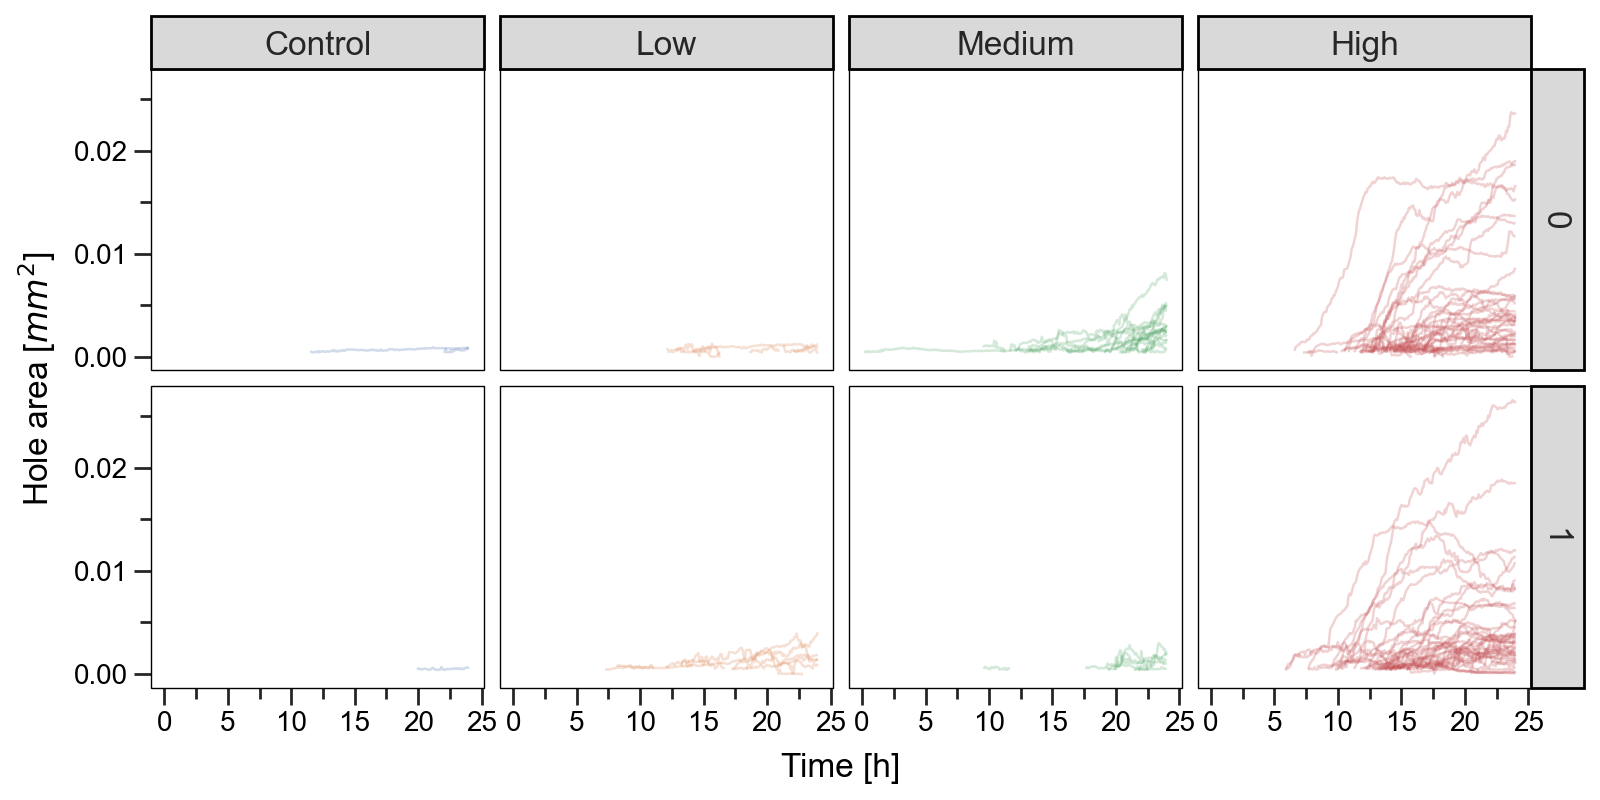

In [533]:
p_hole_area_per_fov = (p9.ggplot(df_holes_props,
          p9.aes(x = 'time_h',
                 y = 'area_mm2',
                 group = 'label'))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 0.25)
+ p9.scale_color_manual(name = 'Condition', values=colpal_hex)
+ p9.facet_grid('fov_index', 'condition')
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area [$mm^2$]')
+ p9.theme(legend_position='none',
              figure_size=(8, 4),
              panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))
)

p_hole_area_per_fov

In [516]:
p9.ggsave(p_hole_area_per_fov, '../../data/5_hole_tracking/output-plots/hole_area_per_fov.pdf', width = 8, height = 4)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area_per_fov.pdf


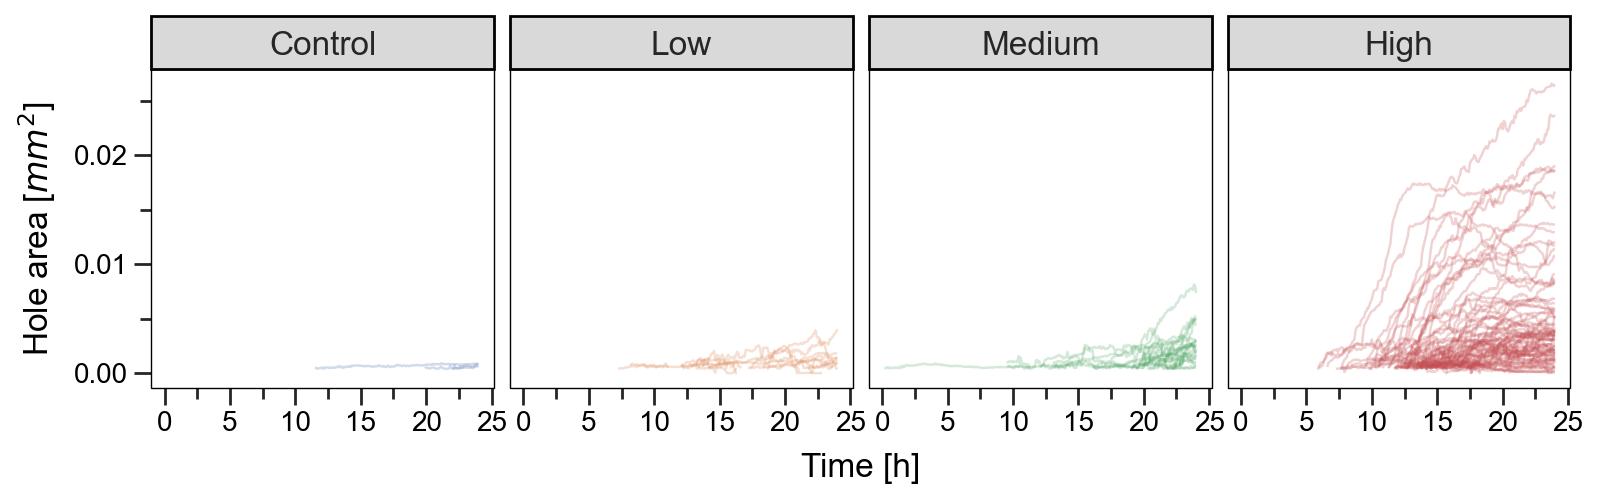

In [534]:
p_hole_area = (p9.ggplot(df_holes_props,
          p9.aes(x = 'time_h',
                 y = 'area_mm2',
                 group = 'fov_label'))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 0.25)
+ p9.scale_color_manual(name = 'Condition', values=colpal_hex)
+ p9.facet_wrap('condition', nrow = 1)
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area [$mm^2$]')
+ p9.theme(legend_position='none',
            figure_size=(8, 2.5),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12)))

p_hole_area

In [524]:
p9.ggsave(p_hole_area, '../../data/5_hole_tracking/output-plots/hole_area.pdf', width = 8, height = 2.5)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area.pdf


In [568]:
# Aggregate df_holes_props to calculate the total area_mm2 per condition, fov, and frame
df_holes_aggr = df_holes_props.groupby(['condition', 'frame'], observed=True)['area_mm2'].sum().reset_index()
df_holes_aggr['area_mm2_frac'] = df_holes_aggr['area_mm2'] / (2*.00064**2 * 1024**2)
df_holes_aggr['time_h'] = df_holes_aggr['frame'] * SAMPLE_PERIOD_MIN/60
df_holes_aggr


,condition,frame,area_mm2,area_mm2_frac,time_h
0,Control,138,0.000551,0.000641,11.500000
1,Control,140,0.000419,0.000488,11.666667
2,Control,141,0.000439,0.000511,11.750000
3,Control,143,0.000485,0.000565,11.916667
4,Control,144,0.000518,0.000603,12.000000
...,...,...,...,...,...
849,High,284,0.408106,0.475098,23.666667
850,High,285,0.408676,0.475761,23.750000
851,High,286,0.408932,0.476059,23.833333
852,High,287,0.411107,0.478592,23.916667


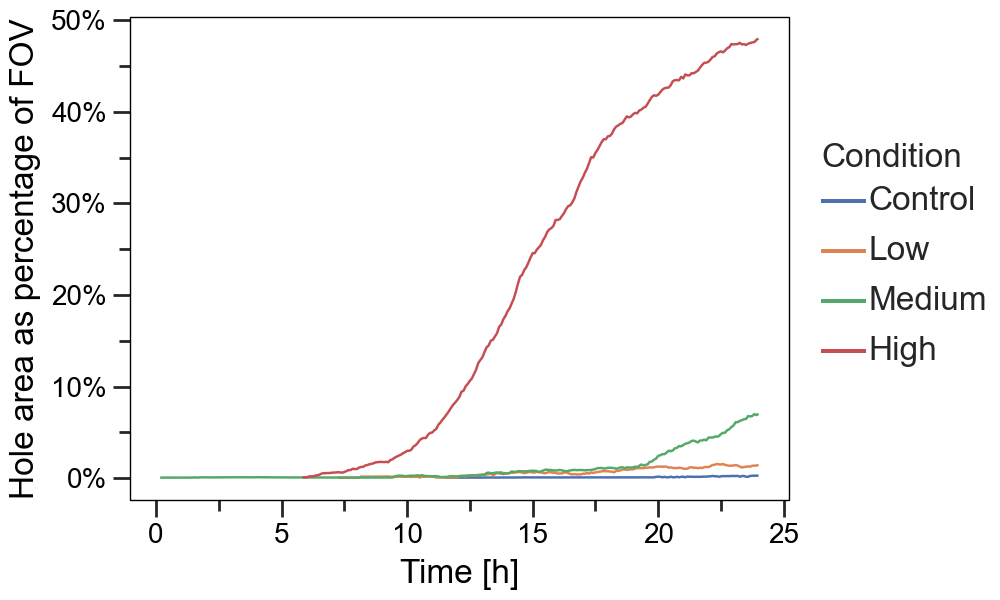

In [582]:
p_hole_area_perc = (p9.ggplot(df_holes_aggr,
          p9.aes(x = "time_h",
                 y = "area_mm2_frac"))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 1)
+ p9.scale_color_manual(name = 'Condition', values=colpal_hex)
+ p9.scale_y_continuous(labels=percent_format())
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area as percentage of FOV')
+ p9.theme(legend_position='right',
            figure_size=(5, 3),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))              
)

p_hole_area_perc

In [583]:
p9.ggsave(p_hole_area_perc, '../../data/5_hole_tracking/output-plots/hole_area_perc_fov.pdf', width = 5, height = 3)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area_perc_fov.pdf


### Hole count over time

In [575]:
df_hole_counts = df_holes_props.groupby(['condition', 'frame'], observed=True).size().reset_index(name='counts')

# sort holes according to condition
df_hole_counts['condition'] = pd.Categorical(df_hole_counts['condition'], v_cond_order)
df_hole_counts = df_hole_counts.sort_values(by = ['condition', 'frame'])

# Add a column with time in hours
df_hole_counts['time_h'] = df_hole_counts['frame'] * SAMPLE_PERIOD_MIN/60
df_hole_counts

,condition,frame,counts,time_h
0,Control,138,1,11.500000
1,Control,140,1,11.666667
2,Control,141,1,11.750000
3,Control,143,1,11.916667
4,Control,144,1,12.000000
...,...,...,...,...
849,High,284,76,23.666667
850,High,285,76,23.750000
851,High,286,76,23.833333
852,High,287,75,23.916667


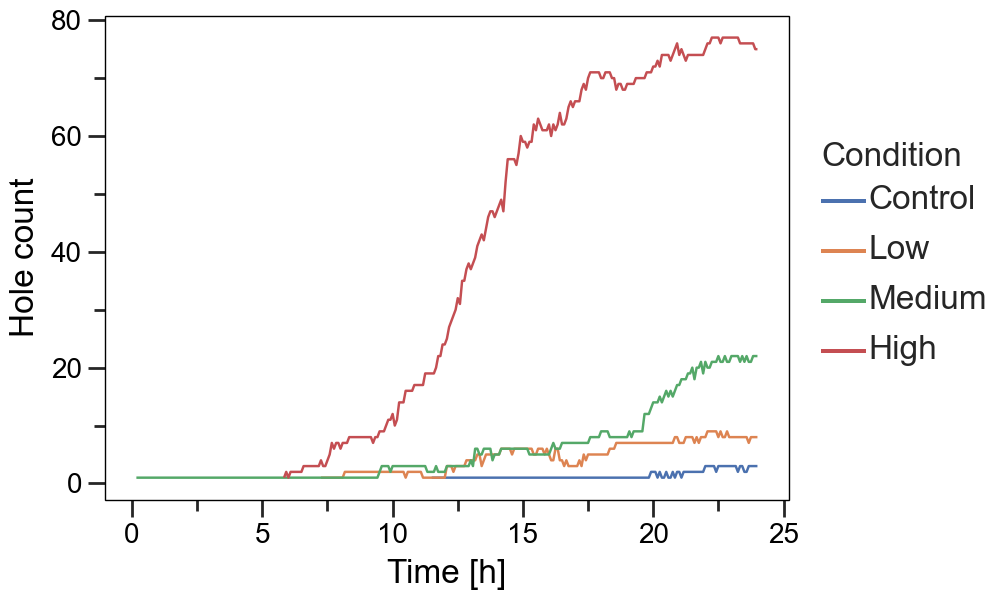

In [584]:
p_hole_count = (p9.ggplot(df_hole_counts,
          p9.aes(x = "time_h",
                 y = "counts"))
+ p9.geom_path(p9.aes(color = 'condition'), 
               alpha = 1)
+ p9.scale_color_manual(name = 'Condition', 
                            values=colpal_hex)
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole count')
+ p9.theme(legend_position='right',
            figure_size=(5, 3),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))
)

p_hole_count

In [585]:
p9.ggsave(p_hole_count, '../../data/5_hole_tracking/output-plots/hole_count.pdf', width = 5, height = 3)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_count.pdf


### Speed of hole formation

In [587]:
df_area_diff = df_holes_props.groupby(['condition', 'fov', 'label'], observed=True)['area_um2'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index(name='area_um2_diff')
df_time_diff = df_holes_props.groupby(['condition', 'fov', 'label'], observed=True)['time_h'].agg(lambda x: (x.iloc[-1] - x.iloc[0])*3600).reset_index(name='time_s_diff')

df_holes_speed = pd.merge(df_area_diff, df_time_diff, on=['condition', 'fov', 'label'], how='inner')
df_holes_speed['speed_um2_s'] = df_holes_speed['area_um2_diff'] /  df_holes_speed['time_s_diff']
df_holes_speed


,condition,fov,label,area_um2_diff,time_s_diff,speed_um2_s
0,Control,0,5,294.9120,45000.0,0.006554
1,Control,0,6,445.6448,7200.0,0.061895
2,Control,1,4,235.9296,14700.0,0.016050
3,Low,2,5,301.4656,42900.0,0.007027
4,Low,2,7,-773.3248,12600.0,-0.061375
...,...,...,...,...,...,...
134,High,7,71,2994.9952,18000.0,0.166389
135,High,7,73,1546.6496,16800.0,0.092062
136,High,7,76,-242.4832,13200.0,-0.018370
137,High,7,77,557.0560,11100.0,0.050185


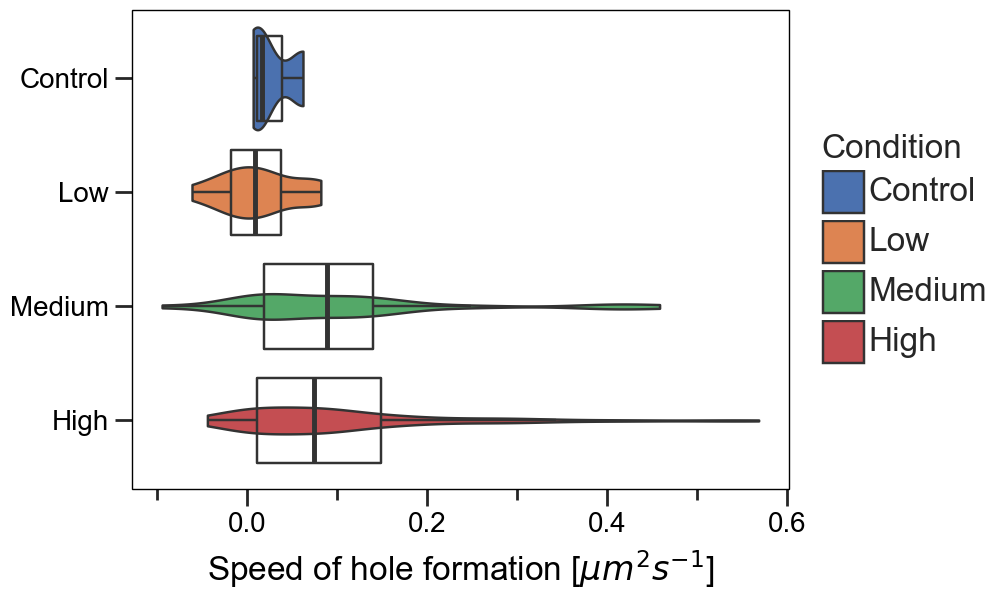

In [588]:
p_hole_speed = (p9.ggplot(df_holes_speed,
           p9.aes(y = 'speed_um2_s',
                  x = 'condition',
                  fill = 'condition'))
    + p9.geom_violin()
    + p9.geom_boxplot(fill = 'none', outlier_color = 'none')
    + p9.scale_fill_manual(name = 'Condition', values=colpal_hex)
    + p9.coord_flip()
    + p9.scale_x_discrete(limits = v_cond_order[::-1])
    + p9.ylab("Speed of hole formation [$\mu m^2 s^{-1}$]")
    + p9.xlab("")
#    + p9.theme_bw()
    + p9.theme_matplotlib()
    + p9.theme(
        legend_position='right',
        figure_size=(5, 3),
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

p_hole_speed

In [590]:
p9.ggsave(p_hole_speed, '../../data/5_hole_tracking/output-plots/hole_speed.pdf', width = 5, height = 3)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_speed.pdf


In [591]:
# Calculate the number of rows per condition and fov
df_row_counts = df_holes_speed.groupby(['condition'], observed = True).size().reset_index(name='row_count')
df_row_counts


,condition,row_count
0,Control,3
1,Low,14
2,Medium,29
3,High,93


# Trash?

In [ ]:
# Extract the speed values for each condition
control_speed = df_aggr[df_aggr['condition'] == 'Control']['speed']
low_dose_speed = df_aggr[df_aggr['condition'] == 'Low Dose']['speed']
medium_dose_speed = df_aggr[df_aggr['condition'] == 'Medium Dose']['speed']
high_dose_speed = df_aggr[df_aggr['condition'] == 'High Dose']['speed']

# Perform the Kruskal-Wallis test
statistic, p_value_kruskal = kruskal(control_speed, low_dose_speed, medium_dose_speed, high_dose_speed)

# Print the test results
print("Kruskal-Wallis Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value_kruskal}")

# perform post-hoc analysis to determine which conditions are significantly different
# Perform pairwise Mann-Whitney U tests
p_values = {}
for group1, group2 in [('Control', 'Low Dose'), ('Control', 'Medium Dose'), ('Control', 'High Dose'), ('Low Dose', 'Medium Dose'), ('Low Dose', 'High Dose'), ('Medium Dose', 'High Dose')]:
    group1_speed = df_aggr[df_aggr['condition'] == group1]['speed']
    group2_speed = df_aggr[df_aggr['condition'] == group2]['speed']
    statistic, p_value = mannwhitneyu(group1_speed, group2_speed)
    p_values[(group1, group2)] = p_value

# Print the post-hoc test results and mark significant differences
print("Mann-Whitney U Test:")
for (group1, group2), p_value in p_values.items():
    if p_value < 0.05:
        print(f"{group1} vs {group2}: p-value = {p_value} (Significant)")
    else:
        print(f"{group1} vs {group2}: p-value = {p_value}")

In [ ]:
sns.color_palette(n_colors=4)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
# Assuming all_df_agg, p_value_kruskal, and p_values are predefined
# Set seaborn style
# rc config to save svgs as text
sns.set_theme(style='white')
plt.rcParams['svg.fonttype'] = 'none'
# set font to Arial
plt.rcParams['font.sans-serif'] = "Arial"
# set font size to 8 for everything
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'axes.titlesize': 8
                     , 'axes.labelsize': 8
                     , 'xtick.labelsize': 8
                     , 'ytick.labelsize': 8
                     , 'legend.fontsize': 8
                     , 'legend.title_fontsize': 8
                     , 'figure.titlesize': 8
                     })

# Set colormap
colormap = sns.color_palette(palette=colpal, n_colors=len(df_aggr['condition'].unique()))

# Plot the speed of hole formation per condition
g = sns.displot(data=df_aggr, x='speed', palette=colormap, hue='condition', kde=True)

# categoriy to color mapping
category_to_color = {category: color for category, color in zip(df_aggr['condition'].unique(), colormap)}

# Add median lines and calculate sample sizes
medians = df_aggr.groupby('condition')['speed'].median()
sample_sizes = df_aggr.groupby('condition').size()
for idx, (condition, median) in enumerate(medians.items()):
    plt.axvline(median, color=colormap[idx], linestyle='--', alpha=0.5)

plt.xlabel('Speed of Hole Formation (sq. um/min)')
plt.ylabel('Number of Holes across 2 FOVs')

# Prepare table data
cell_text = [['Kruskal-Wallis', '-', "-", f"{p_value_kruskal:.3f}*"]]
columns = ['Test Type', 'Group1', "Group2", 'p-value']

for idx, ((group1, group2), p_value) in enumerate(p_values.items()):
    significance = "*" if p_value < 0.05 else ""
    n_group1 = sample_sizes[group1]
    n_group2 = sample_sizes[group2]
    cell_text.append(['Mann-Whitney U Test', f"{group1}, n={n_group1}", f"{group2}, n={n_group2}", f"{p_value:.3f}{significance}"])

# Add table
table = plt.table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='bottom', bbox=[0.0, -0.6, 1.0, 0.4], fontsize=8)

# Color the cells
for idx, (group1, group2) in enumerate([('Control', 'Low Dose'), ('Control', 'Medium Dose'), ('Control', 'High Dose'), ('Low Dose', 'Medium Dose'), ('Low Dose', 'High Dose'), ('Medium Dose', 'High Dose')]):
    cell1 = table[(idx + 2, 1)]  # +2 because the first row is the header and the second row is for Kruskal-Wallis
    cell2 = table[(idx + 2, 2)]
    cell1.set_facecolor(category_to_color[group1])
    cell2.set_facecolor(category_to_color[group2])
    cell1.set_text_props(color='white')
    cell2.set_text_props(color='white')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Create a custom colormap: white (non-significant, high p-value) to green (significant, low p-value)
green_cmap = LinearSegmentedColormap.from_list("custom_turqouise", ["darkgrey", "white"], N=10)
norm = plt.Normalize(0, 0.05)  # Normalize p-value range from 0 to 0.05 for significance

# color first pvalue cell
cell1 = table[(1, 3)]
cell1.set_facecolor(green_cmap(norm(p_value_kruskal)))
cell1.set_text_props(color='black')


# Color the 'p-value' cells based on their significance level
for idx, ((group1, group2), p_value) in enumerate(p_values.items()):
    p_value_cell = table[(idx + 2, 3)]  # +2 to account for header and Kruskal-Wallis row, 3 for the 'p-value' column
    cell_color = green_cmap(norm(p_value))  # Apply the custom green colormap
    p_value_cell.set_facecolor(cell_color)
    # Adjust text color for readability
    text_color = 'black'
    p_value_cell.set_text_props(color=text_color)

# Adding a colorbar for the custom green colormap
cbar_ax = plt.gcf().add_axes([0.1, -0.15, 0.8, 0.02])  # Position for the colorbar
cb = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=green_cmap, norm=norm, orientation='horizontal')
cb.set_label('p-value significance')

# Adjust layout to accommodate the colorbar
plt.subplots_adjust(bottom=0.45)

plt.savefig('speed_of_hole_formation_with_green_colored_table.svg', dpi=150)

plt.show()

In [136]:
# calculate number of holes per frame
number_of_holes = df_holes_props.groupby(['condition', 'frame']).size().reset_index(name='counts')

# calculate the average area of holes per frame
average_area = df_holes_props.groupby(['condition', 'frame'])['area'].sum().reset_index(name='average_area')

# merge the two dataframes
merged = pd.merge(number_of_holes, average_area, on=['condition', 'frame'])

In [ ]:
merged

In [ ]:
# correlate the number of holes with the average area of holes, fitting a linear model per condition, and plotting the results
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

merged_filtered = merged[merged['counts'] <= merged.query('condition == "Medium Dose"')['counts'].max()]
# fit a linear model to the data
for cond in merged_filtered['condition'].unique():
    data = merged_filtered[merged_filtered['condition'] == cond]
    model = ols('counts ~ average_area', data=data).fit()
    # print(model.summary())


# plot the results
fig, ax = plt.subplots()
for cond in merged_filtered['condition'].unique():
    data = merged_filtered[merged_filtered['condition'] == cond]
    sns.regplot(data=data, x='counts', y='average_area', ax=ax, label=cond)
plt.legend()

plt.savefig('correlation_average_area_counts.png')

In [ ]:
im_raw[-1].shape

In [ ]:
viewer = napari.Viewer()
viewer.add_image(im_raw[-1][..., 1], name='raw', blending='additive', colormap='gray_r', contrast_limits=[100, 6000])
viewer.add_labels(l_holes[-1], name='filtered_events')

In [176]:
samples = np.linspace(0, 288, 4, dtype=int)

viewer = napari.Viewer()
viewer.add_image(im_raw[-1][..., 1], name='raw', blending='additive', colormap='gray_r', contrast_limits=[100, 6000])
viewer.add_labels(l_holes[-1], name='filtered_events')

rgb_events_high_dose = []
rgb_high_dose = []
viewer.layers['raw'].visible = True
viewer.layers['filtered_events'].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events_high_dose.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['filtered_events'].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_high_dose.append(render_as_rgb(viewer, upsample_factor=1))

viewer.close()

In [177]:
samples = np.linspace(0, 288, 4, dtype=int)

viewer = napari.Viewer()
viewer.add_image(im_raw[2][..., 1], name='raw', blending='additive', colormap='gray_r', contrast_limits=[100, 6000])
viewer.add_labels(l_holes[2], name='filtered_events')

rgb_events_low_dose = []
rgb_low_dose = []
viewer.layers['raw'].visible = True
viewer.layers['filtered_events'].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events_low_dose.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['filtered_events'].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_low_dose.append(render_as_rgb(viewer, upsample_factor=1))

viewer.close()

In [ ]:
samples

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'
# set font to arial
plt.rcParams['font.sans-serif'] = "Arial"


fig, ax = plt.subplots(2,4, figsize=(10,5))

for idx, val in enumerate(samples):
    ax[0, idx].imshow(rgb_events_low_dose[idx])
    ax[0, idx].axis('off')
    # ax[0, idx].set_title(f'{val*3} s')
    # in minutes
    ax[0, idx].set_title(f'{val*5:.0f} min')

for idx, val in enumerate(samples):
    ax[1, idx].imshow(rgb_events_high_dose[idx])
    ax[1, idx].axis('off')
    if val == samples[-1]:
        scalebar = ScaleBar(0.64, "um", length_fraction=0.1, location='lower right', scale_loc='none', box_alpha=0, width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-3)
plt.savefig('plots/pannels_toplow_bottom_high.svg', dpi=600)
# scalebar = 50 um